In [82]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [14]:
clinics_df = pd.read_csv('../data/datos_limpios_p1.csv', parse_dates=[2, 12, 13, 15, 17])
clinics_df['HourOfDay'] = clinics_df['TurnoInicioDateTime'].dt.hour
clinics_df.head(2)

C:\Users\cumpl\AppData\Local\Temp\ipykernel_36516\3127935692.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clinics_df = pd.read_csv('../data/datos_limpios_p1.csv', parse_dates=[2, 12, 13, 15, 17])
C:\Users\cumpl\AppData\Local\Temp\ipykernel_36516\3127935692.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clinics_df = pd.read_csv('../data/datos_limpios_p1.csv', parse_dates=[2, 12, 13, 15, 17])


,Orden,Sucursal,FechaID,HoraLLegada,TurnoID,Turno,TurnoTipo,TurnoHoraInicio,TurnoHoraFin,TurnoMinutosEspera,TAPRecepcionMinutos,TAPRecepcionCaja,TurnoInicioDateTime,TurnoFinDateTime,TurnoGrupo,WaitingTimeInLine,HourOfDay,TimeInService,HasTimeInService
0,424722,CULIACAN,2024-03-01,6,41691626,P001,Estudio Pendiente,06:32:32,06:34:58,2.43,0.58,1135.0,2024-03-01 06:32:32,2024-03-01 06:34:58,P,0 days 00:02:26,6,0 days 00:00:34.800000,1
1,424738,CULIACAN,2024-03-01,6,41696473,N020,Solicitar Estudios,06:47:18,07:06:33,19.25,4.42,1134.0,2024-03-01 06:47:18,2024-03-01 07:06:33,N,0 days 00:19:15,6,0 days 00:04:25.200000,1


In [24]:
clinics_df['WaitingTimeInLine'] = pd.to_timedelta(clinics_df['WaitingTimeInLine'])

In [25]:
clinics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30578 entries, 0 to 30577
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Orden                30578 non-null  int64          
 1   Sucursal             30578 non-null  object         
 2   FechaID              30578 non-null  datetime64[ns] 
 3   HoraLLegada          30578 non-null  int64          
 4   TurnoID              30578 non-null  int64          
 5   Turno                30578 non-null  object         
 6   TurnoTipo            30578 non-null  object         
 7   TurnoHoraInicio      30578 non-null  object         
 8   TurnoHoraFin         30578 non-null  object         
 9   TurnoMinutosEspera   30578 non-null  float64        
 10  TAPRecepcionMinutos  26316 non-null  float64        
 11  TAPRecepcionCaja     26316 non-null  float64        
 12  TurnoInicioDateTime  30578 non-null  datetime64[ns] 
 13  TurnoFinDateTime

## 20 minutes threshold

In [34]:
# Define the threshold duration (20 minutes)
threshold = pd.Timedelta(minutes=20)
clinics_df[
    clinics_df['WaitingTimeInLine'] > threshold
].groupby('Sucursal')['WaitingTimeInLine'].size() / clinics_df.groupby('Sucursal')['WaitingTimeInLine'].size() * 100

Sucursal
CULIACAN                     3.230370
CULIACAN CAÑADAS             5.496368
CULIACAN COLEGIO MILITAR    28.724641
CULIACAN LA CONQUISTA       11.045259
Name: WaitingTimeInLine, dtype: float64

Arriba se muestra el porcentaje de observaciones que superaron los 20 minutos de tiempo de espera en la fila antes de ser atendidos (o de haberse retirado) por sucursal. Nuestro objetivo es reducir estos porcentajes.

In [44]:
clinics_df[
    clinics_df['WaitingTimeInLine'] > threshold
].shape[0] / clinics_df.shape[0] * 100

10.769180456537379

El 10.77% de toda la base que estamos usando presenta tiempos de espera en la fila antes de ser atendidos de más de 20 minutos.

In [18]:
# clinics_df.loc[0:1, :].to_csv('../data/sample.csv', encoding='utf-8', index=False)

## Service time variability

In [45]:
clinics_df.head()

,Orden,Sucursal,FechaID,HoraLLegada,TurnoID,Turno,TurnoTipo,TurnoHoraInicio,TurnoHoraFin,TurnoMinutosEspera,TAPRecepcionMinutos,TAPRecepcionCaja,TurnoInicioDateTime,TurnoFinDateTime,TurnoGrupo,WaitingTimeInLine,HourOfDay,TimeInService,HasTimeInService
0,424722,CULIACAN,2024-03-01,6,41691626,P001,Estudio Pendiente,06:32:32,06:34:58,2.43,0.58,1135.0,2024-03-01 06:32:32,2024-03-01 06:34:58,P,0 days 00:02:26,6,0 days 00:00:34.800000,1
1,424738,CULIACAN,2024-03-01,6,41696473,N020,Solicitar Estudios,06:47:18,07:06:33,19.25,4.42,1134.0,2024-03-01 06:47:18,2024-03-01 07:06:33,N,0 days 00:19:15,6,0 days 00:04:25.200000,1
2,424754,CULIACAN,2024-03-01,7,41696082,C007,Citado,07:03:23,07:04:14,0.85,2.97,1136.0,2024-03-01 07:03:23,2024-03-01 07:04:14,C,0 days 00:00:51,7,0 days 00:02:58.200000,1
3,424770,CULIACAN,2024-03-01,7,41701275,N039,Solicitar Estudios,07:18:33,07:33:59,15.43,1.68,1137.0,2024-03-01 07:18:33,2024-03-01 07:33:59,N,0 days 00:15:26,7,0 days 00:01:40.800000,1
4,424786,CULIACAN,2024-03-01,7,41704260,N050,Solicitar Estudios,07:30:09,07:50:12,20.05,4.68,1134.0,2024-03-01 07:30:09,2024-03-01 07:50:12,N,0 days 00:20:03,7,0 days 00:04:40.800000,1


In [47]:
clinics_df['TimeInService'] = pd.to_timedelta(clinics_df['TimeInService'])

In [50]:
clinics_df.groupby(['TurnoGrupo'])['TimeInService'].mean()

TurnoGrupo
C   0 days 00:03:41.307112140
F   0 days 00:03:26.737333333
N   0 days 00:03:38.923620215
P   0 days 00:02:41.091113028
Name: TimeInService, dtype: timedelta64[ns]

In [49]:
clinics_df.groupby(['TurnoGrupo', 'TurnoTipo'])['TimeInService'].mean()

TurnoGrupo  TurnoTipo            
C           Citado                  0 days 00:03:41.307112140
F           Cotizacion              0 days 00:04:05.174336283
            Folio Pagado            0 days 00:03:13.848961424
N           Citados sin folio       0 days 00:03:14.962725450
            Solicitar Estudios      0 days 00:03:40.982834835
P           Abono a Lentes          0 days 00:02:17.189473684
            Atención Empresas       0 days 00:03:09.056249999
            Entrega de Resultados      0 days 00:02:06.400000
            Estudio Pendiente       0 days 00:02:06.575999999
            Examen de la Vista      0 days 00:02:16.185267857
            Triage                  0 days 00:03:49.500707547
Name: TimeInService, dtype: timedelta64[ns]

In [51]:
clinics_df.groupby(['Sucursal', 'TurnoGrupo'])['TimeInService'].mean()

Sucursal                  TurnoGrupo
CULIACAN                  C            0 days 00:04:09.278181818
                          F            0 days 00:03:55.317073170
                          N            0 days 00:04:10.182184197
                          P            0 days 00:03:19.720126782
CULIACAN CAÑADAS          C            0 days 00:02:58.152913198
                          F            0 days 00:02:29.144680851
                          N            0 days 00:03:14.539167374
                          P            0 days 00:02:08.568218623
CULIACAN COLEGIO MILITAR  C            0 days 00:03:47.965145228
                          F            0 days 00:03:32.687441860
                          N            0 days 00:03:23.620951619
                          P            0 days 00:02:32.397270245
CULIACAN LA CONQUISTA     C            0 days 00:03:02.149640287
                          F            0 days 00:02:14.099999999
                          N            0 days 00:02:5

In [52]:
clinics_df.groupby('HourOfDay')['TimeInService'].mean()

HourOfDay
5       0 days 00:03:50.400000
6    0 days 00:03:31.830659025
7    0 days 00:03:42.828815733
8    0 days 00:03:35.949122807
9    0 days 00:03:32.568268947
10   0 days 00:03:32.372142857
11   0 days 00:03:26.432760363
12   0 days 00:03:25.226938775
13   0 days 00:03:23.387463976
14   0 days 00:03:22.991351351
15   0 days 00:03:22.233361847
16   0 days 00:03:16.504907975
17   0 days 00:03:05.382812499
18   0 days 00:03:19.475409836
Name: TimeInService, dtype: timedelta64[ns]

## Number of Service Windows

In [61]:
clinics_df[
    clinics_df['HasTimeInService'] == 0
]['TAPRecepcionCaja'].isna().sum() / clinics_df[
    clinics_df['HasTimeInService'] == 0
].shape[0]

np.float64(1.0)

Todas las observaciones que no tienen registrado un 'id' de la caja en la que fueron atendidos tampoco tienen su tiempo de servicio registrado. Esto hace sentido.

In [74]:
clinics_df.groupby(
    'Sucursal'
)['TAPRecepcionCaja'].apply(
    lambda x: len([v for v in x.unique() if not(np.isnan(v))])
)

Sucursal
CULIACAN                    10
CULIACAN CAÑADAS             6
CULIACAN COLEGIO MILITAR     4
CULIACAN LA CONQUISTA        3
Name: TAPRecepcionCaja, dtype: int64

Esos son las cajas (ventanillas) disponibles en cada sucursal. 

## Service Process Analysis

In [76]:
clinics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30578 entries, 0 to 30577
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Orden                30578 non-null  int64          
 1   Sucursal             30578 non-null  object         
 2   FechaID              30578 non-null  datetime64[ns] 
 3   HoraLLegada          30578 non-null  int64          
 4   TurnoID              30578 non-null  int64          
 5   Turno                30578 non-null  object         
 6   TurnoTipo            30578 non-null  object         
 7   TurnoHoraInicio      30578 non-null  object         
 8   TurnoHoraFin         30578 non-null  object         
 9   TurnoMinutosEspera   30578 non-null  float64        
 10  TAPRecepcionMinutos  26316 non-null  float64        
 11  TAPRecepcionCaja     26316 non-null  float64        
 12  TurnoInicioDateTime  30578 non-null  datetime64[ns] 
 13  TurnoFinDateTime

In [79]:
# Convert TimeInService to total seconds
clinics_df['TimeInService_seconds'] = clinics_df['TimeInService'].dt.total_seconds()

# to minutes:
clinics_df['TimeInService_minutes'] = clinics_df['TimeInService'].dt.total_seconds() / 60

# It's crucial to handle any potential NaT (Not a Time) or negative timedelta values
# if they exist in your data, as they can cause errors in fitting.
# For example, you might want to remove or impute them:
service_times = clinics_df.dropna(subset=['TimeInService_minutes'])['TimeInService_minutes']
# service_time = clinics_df[clinics_df['TimeInService_seconds'] > 0] # Service time should be positive

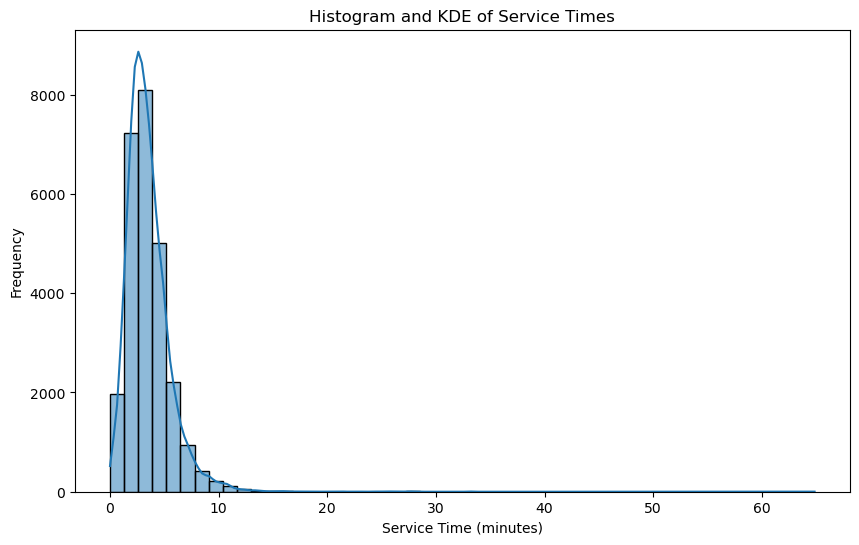

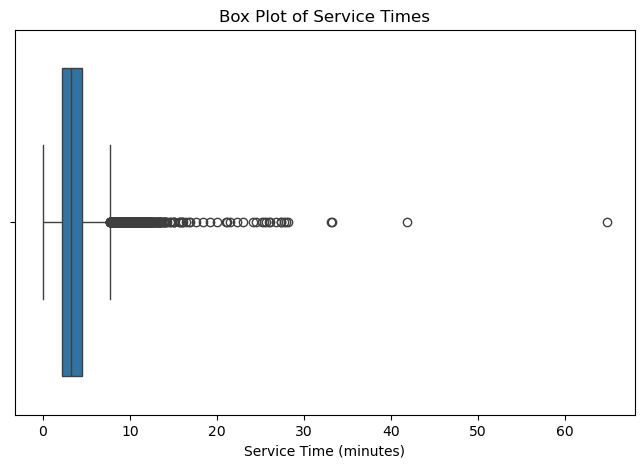

In [84]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(service_times, kde=True, bins=50) # Adjust bins as needed
plt.title('Histogram and KDE of Service Times')
plt.xlabel('Service Time (minutes)')
plt.ylabel('Frequency')
plt.show()

# Box plot (to identify outliers)
plt.figure(figsize=(8, 5))
sns.boxplot(x=service_times)
plt.title('Box Plot of Service Times')
plt.xlabel('Service Time (minutes)')
plt.show()

In [108]:
service_times = service_times[service_times > 0] # Ensure positive values for distributions like exponential and log-normal

# --- Fit Exponential Distribution ---
# The exponential distribution is defined by a 'loc' (location) and 'scale' parameter.
# For service times, loc is often 0. The scale is 1/lambda (mean).
exp_params = stats.expon.fit(service_times)  # floc=0 fixes the location at 0
exp_dist = stats.expon(loc=exp_params[0], scale=exp_params[1])
print(f"Exponential Fit Parameters: loc={exp_params[0]}, scale={exp_params[1]} (mean={exp_params[1]})")

# --- Fit Log-Normal Distribution ---
# The log-normal distribution takes three parameters from scipy's fit:
# shape (s, which is sigma), loc (location offset), and scale (exp(mu)).
# If you expect your data to start from 0, you can set loc=0.
lognorm_params = stats.lognorm.fit(service_times) # floc=0 fixes the location at 0
lognorm_dist = stats.lognorm(s=lognorm_params[0], loc=lognorm_params[1], scale=lognorm_params[2])
print(f"Log-Normal Fit Parameters: shape(sigma)={lognorm_params[0]}, loc={lognorm_params[1]}, scale(exp(mu))={lognorm_params[2]}")

# You can also try other distributions like Gamma, Weibull, etc.
# --- Fit Gamma Distribution ---
# gamma_params = stats.gamma.fit(data, floc=0)
# gamma_dist = stats.gamma(a=gamma_params[0], loc=gamma_params[1], scale=gamma_params[2])
# print(f"Gamma Fit Parameters: shape(a)={gamma_params[0]}, loc={gamma_params[1]}, scale={gamma_params[2]}")

# --- Fit Weibull (Minimum) Distribution ---
# weibull_min_params = stats.weibull_min.fit(data, floc=0)
# weibull_min_dist = stats.weibull_min(c=weibull_min_params[0], loc=weibull_min_params[1], scale=weibull_min_params[2])
# print(f"Weibull Min Fit Parameters: shape(c)={weibull_min_params[0]}, loc={weibull_min_params[1]}, scale={weibull_min_params[2]}")

Exponential Fit Parameters: loc=0.02, scale=3.4991259737789653 (mean=3.4991259737789653)
Log-Normal Fit Parameters: shape(sigma)=0.3729782115414504, loc=-1.4322215688341433, scale(exp(mu))=4.612167350845283


In [109]:
exp_dist.kwds['loc'], exp_dist.kwds['scale']

(0.02, 3.4991259737789653)

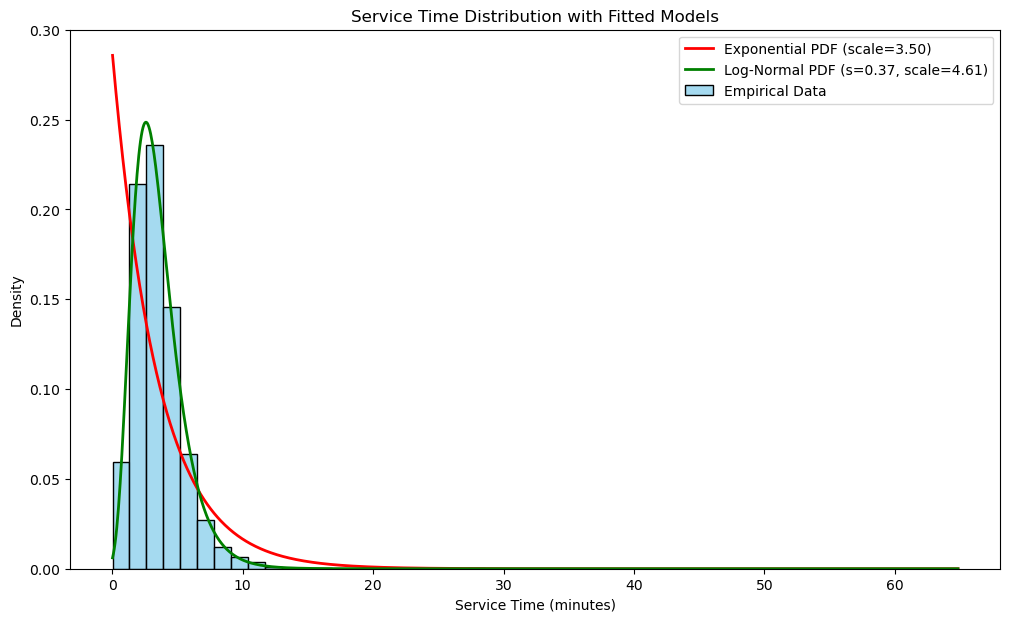

In [110]:
plt.figure(figsize=(12, 7))
sns.histplot(service_times, bins=50, stat='density', kde=False, label='Empirical Data', color='skyblue')

# Plot fitted distributions
x = np.linspace(service_times.min(), service_times.max(), 1000)

plt.plot(x, exp_dist.pdf(x), 'r-', lw=2, label=f'Exponential PDF (scale={exp_params[1]:.2f})')
plt.plot(x, lognorm_dist.pdf(x), 'g-', lw=2, label=f'Log-Normal PDF (s={lognorm_params[0]:.2f}, scale={lognorm_params[2]:.2f})')
# Add other distributions if you fitted them
# plt.plot(x, gamma_dist.pdf(x), 'm-', lw=2, label='Gamma PDF')
# plt.plot(x, weibull_min_dist.pdf(x), 'y-', lw=2, label='Weibull Min PDF')


plt.title('Service Time Distribution with Fitted Models')
plt.xlabel('Service Time (minutes)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [105]:
exp_dist.

AttributeError: 'rv_continuous_frozen' object has no attribute 'scale'

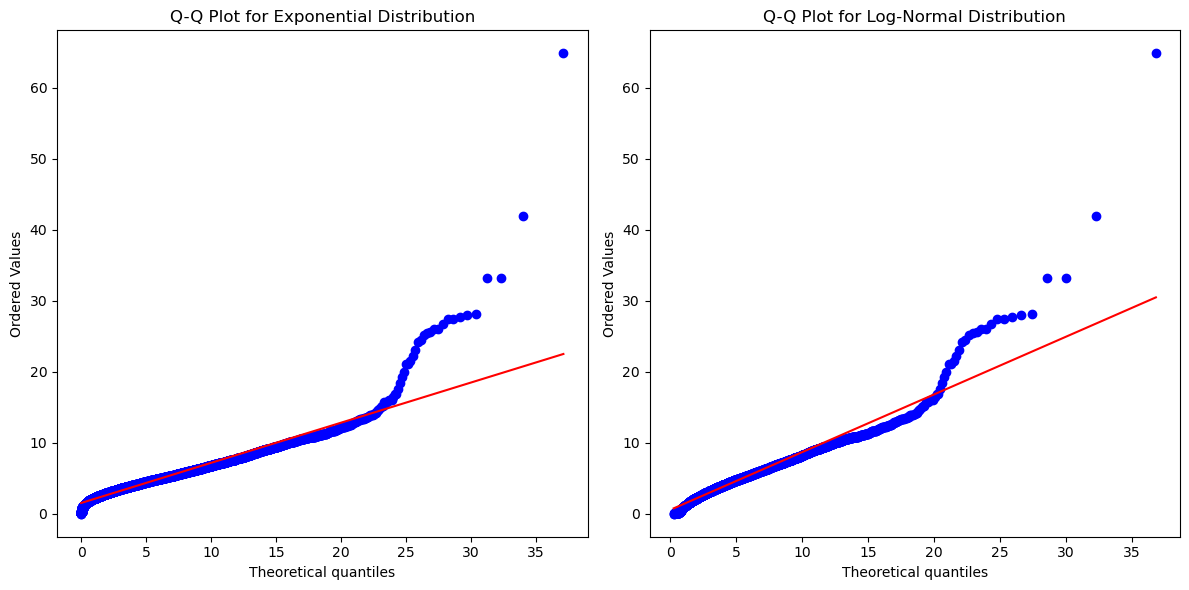

In [88]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(service_times, dist=exp_dist, plot=plt) # Using the fitted distribution object
plt.title('Q-Q Plot for Exponential Distribution')

plt.subplot(1, 2, 2)
stats.probplot(service_times, dist=lognorm_dist, plot=plt) # Using the fitted distribution object
plt.title('Q-Q Plot for Log-Normal Distribution')

plt.tight_layout()
plt.show()

In [91]:
# --- Kolmogorov-Smirnov Test ---
# For KS test, it's better to use the string name of the distribution if its parameters
# were estimated from the data, or pass the fully specified frozen distribution.

ks_stat_exp, ks_p_value_exp = stats.kstest(service_times, exp_dist.cdf) # Compare with the CDF of the fitted distribution
print(f"Exponential KS Test: Statistic={ks_stat_exp:.4f}, P-value={ks_p_value_exp:.4f}")

ks_stat_lognorm, ks_p_value_lognorm = stats.kstest(service_times, lognorm_dist.cdf)
print(f"Log-Normal KS Test: Statistic={ks_stat_lognorm:.4f}, P-value={ks_p_value_lognorm:.4f}")

# Note: The interpretation of p-values from KS test when parameters are estimated from data can be tricky.
# A common approach is to use it for relative comparison: a distribution with a smaller KS statistic
# (and often a larger p-value, though be cautious here) is generally preferred.

# --- Akaike Information Criterion (AIC) / Bayesian Information Criterion (BIC) ---
# These are useful for comparing models with different numbers of parameters.
# Lower AIC/BIC values indicate a better fit, penalizing model complexity.
# You usually need the log-likelihood for these. Scipy's fit methods don't directly
# return log-likelihood for all distributions, but the frozen distribution's logpdf can be used.

from scipy import stats
import numpy as np

def calculate_aic_bic(data, dist_frozen):
    """
    Calculates AIC and BIC for a given dataset and a frozen scipy distribution.

    Parameters:
    data (array-like): The data that was used to fit the distribution.
    dist_frozen (scipy.stats.rv_continuous_frozen): The frozen distribution object
                                                    (e.g., result of stats.expon(loc=l, scale=s)).

    Returns:
    tuple: (aic, bic)
    """
    log_likelihood = np.sum(dist_frozen.logpdf(data))
    
    k = 0  # Initialize k (number of estimated parameters)

    # Determine k based on the distribution type and how it was fitted in your example code.
    # This assumes 'floc=0' was used for fitting exponential and log-normal,
    # meaning 'loc' was fixed and not estimated.
    
    # Access the distribution name via dist_frozen.dist.name
    if dist_frozen.dist.name == stats.expon.name:
        # For stats.expon.fit(data, floc=0), 'loc' is fixed (at 0), 
        # and 'scale' is estimated.
        # Parameters for expon are (loc, scale).
        k = 1  # Only 'scale' was estimated.
    elif dist_frozen.dist.name == stats.lognorm.name:
        # For stats.lognorm.fit(data, floc=0), 'loc' is fixed (at 0),
        # 's' (shape) and 'scale' are estimated.
        # Parameters for lognorm are (s, loc, scale).
        k = 2  # 's' (shape) and 'scale' were estimated.
    elif dist_frozen.dist.name == stats.gamma.name:
        # If you also fitted gamma with floc=0:
        # Parameters for gamma are a (shape), loc, scale.
        # 'a' (shape) and 'scale' would be estimated.
        k = 2 
    elif dist_frozen.dist.name == stats.weibull_min.name:
        # If you also fitted weibull_min with floc=0:
        # Parameters for weibull_min are c (shape), loc, scale.
        # 'c' (shape) and 'scale' would be estimated.
        k = 2
    else:
        # If k is not explicitly defined for a distribution and its fitting method,
        # it's safer to raise an error. Calculating k generically for a frozen
        # distribution without knowing which parameters were fixed during fitting is error-prone.
        raise ValueError(
            f"The number of estimated parameters (k) for AIC/BIC calculation "
            f"is not specifically defined for the distribution: '{dist_frozen.dist.name}'. "
            f"Please update the 'calculate_aic_bic' function to include logic for this "
            f"distribution, considering any parameters that were fixed during the fitting process (e.g., using floc, fscale)."
        )

    n = len(data)
    if n == 0:
        # Handle empty data case to avoid log(0) or division by zero if n is used elsewhere.
        print("Warning: Empty data provided to calculate_aic_bic. Returning NaN for AIC/BIC.")
        return np.nan, np.nan 

    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(n) - 2 * log_likelihood # np.log is natural logarithm
    
    return aic, bic


aic_exp, bic_exp = calculate_aic_bic(service_times, exp_dist)
aic_lognorm, bic_lognorm = calculate_aic_bic(service_times, lognorm_dist)

print(f"Exponential: AIC={aic_exp:.2f}, BIC={bic_exp:.2f}")
print(f"Log-Normal: AIC={aic_lognorm:.2f}, BIC={bic_lognorm:.2f}")

Exponential KS Test: Statistic=0.2485, P-value=0.0000
Log-Normal KS Test: Statistic=0.0661, P-value=0.0000
Exponential: AIC=118851.73, BIC=118859.91
Log-Normal: AIC=107272.20, BIC=107288.56


"A smaller KS statistic and a larger p-value suggest a better fit."

In [115]:
import sys
import os

# Get the absolute path of the current notebook's directory
notebook_dir = os.path.dirname(os.path.abspath("__file__")) # For .py files
# If in a Jupyter notebook, you might need:
# notebook_dir = os.getcwd() # Gets the directory where the notebook is running

# Get the absolute path of the project root (one level up from 'notebooks')
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add the project root to sys.path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)

In [119]:
# Now import from src is possible
from src.services import distribution
from src.external_systems import exponential_dist_scipy

In [121]:
distribution_model = distribution.Distribution()
exponential_distribution_model = exponential_dist_scipy.ExponentialDistributionScipy()

In [124]:
exp_params = distribution_model.fit_distribution(
    service_times, exponential_distribution_model
)
exp_dist = stats.expon(
    loc=exp_params[0], scale=exp_params[1]
)
print(f"Exponential Fit Parameters: loc={exp_params[0]}, scale={exp_params[1]}")

Exponential Fit Parameters: loc=0.02, scale=3.4991259737789653


In [126]:
clinics_df.dropna(subset='TimeInService_minutes').groupby(
    ['Sucursal', 'TurnoGrupo']
)['TimeInService_minutes'].apply(
    lambda x: distribution_model.fit_distribution(
        x, exponential_distribution_model
    )
)

Sucursal                  TurnoGrupo
CULIACAN                  C                            (0.65, 3.5046363636361106)
                          F                            (1.03, 2.8919512195119736)
                          N                             (0.02, 4.149703069954469)
                          P             (0.18000000000000002, 3.1486687797145407)
CULIACAN CAÑADAS          C              (0.7799999999999999, 2.1892152199760013)
                          F                             (0.88, 1.605744680850798)
                          N                             (0.1, 3.1423194562444916)
                          P                            (0.02, 2.1228036437243585)
CULIACAN COLEGIO MILITAR  C                            (0.08, 3.7194190871366066)
                          F                            (0.35, 3.1947906976743408)
                          N                              (0.0, 3.393682526988935)
                          P                             (0.08